# EDA Original Data for Segmentation Model

## Contents
1. Total Data Collected and Label.
2. Number data collected per match.
3. Data Labeling Procedure.
4. Train–Validation Split Statistics.

In [9]:
import os
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib import cm
from matplotlib.patches import Patch

## 1. Total Data Collected and Label.

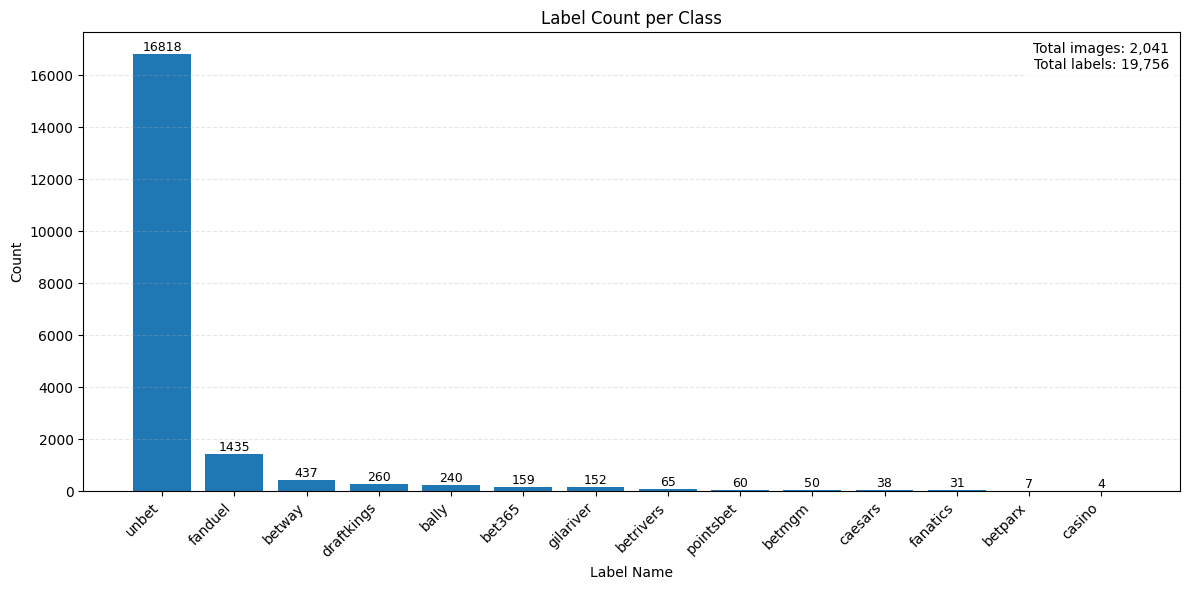

In [ ]:
"""
Script: label_count_bar_chart.py
Purpose:
    - Parse LabelMe JSON files and count annotations per label.
    - Draw a bar chart showing counts for each label.
    - Display the total number of images (JSON files) and total labels (annotations) in the top-right corner.

Inputs:
    - folder_path: Root directory containing LabelMe JSON files (recursively).

Outputs:
    - A matplotlib bar chart (on screen if plt.show() is called).
    - (Optional) You can save the figure by calling plt.savefig("label_counts.png", dpi=200, bbox_inches="tight").

Requirements:
    - Python 3.x
    - matplotlib
"""

# === CONFIGURATION ===
folder_path = "data_json"  # Root directory containing LabelMe JSON files

# === STATE ===
label_counter = Counter()
images_processed = 0  # Number of JSON files successfully read (treated as number of images)

# === WALK ALL JSON FILES (RECURSIVE) ===
for root, _, files in os.walk(folder_path):
    for filename in files:
        if filename.lower().endswith(".json"):
            json_path = os.path.join(root, filename)
            try:
                with open(json_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                images_processed += 1

                # Count label occurrences in each JSON's "shapes"
                for shape in data.get("shapes", []):
                    label = shape.get("label")
                    if label:
                        label_counter[label] += 1
            except Exception as e:
                print(f"Error reading {filename}: {e}")

# === EXIT EARLY IF NO DATA FOUND ===
if not label_counter:
    print("No labels found in the provided JSON directory.")
else:
    # Sort labels by count (descending) for clearer visualization
    labels, counts = zip(*label_counter.most_common())
    total_labels = sum(counts)  # Total number of annotations across all files

    # === PLOT BAR CHART ===
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    bars = ax.bar(range(len(labels)), counts)

    # Axes labels and title
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Count")
    ax.set_xlabel("Label Name")
    ax.set_title("Label Count per Class")

    # Annotate each bar with its value
    for bar, cnt in zip(bars, counts):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{cnt}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    # Show totals in the top-right corner
    ax.text(
        0.99, 0.98,
        f"Total images: {images_processed:,}\nTotal labels: {total_labels:,}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.85, edgecolor="none")
    )

    # Light horizontal gridlines for readability
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    # Optional:
    # plt.savefig("label_counts.png", dpi=200, bbox_inches="tight")
    # plt.show()


Status:
- Unbalanced data: The reason is that the appearance rate of betting advertising logos compared to normal advertising is very low).
- There are some classes with seriously low numbers, which can affect the model training process.

Solution:
- Use argument data techniques to increase the number of data of the missing classes, while increasing data diversity.

## 2. Number data collected per match.

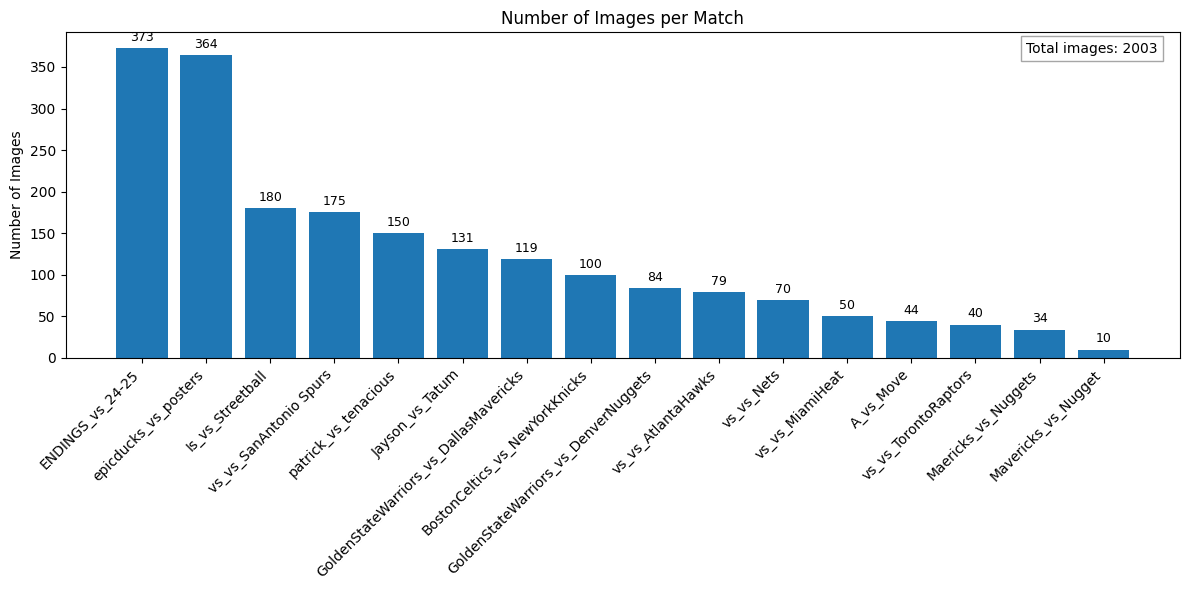

In [17]:
"""
Script: images_per_match_bar_chart.py

Purpose:
    - Parse image filenames to infer match names (team1_vs_team2) based on a 4-digit date token
      embedded in the filename (e.g., "..._TEAM1_TEAM2_1705_...").
    - Count how many images belong to each inferred match.
    - Plot a bar chart showing the number of images per match, annotate counts on bars,
      and display the total number of images in the top-right corner.

Inputs:
    - folder_path: Root directory containing the image files (.jpg, .jpeg, .png).

Outputs:
    - A matplotlib bar chart window.
    - (Optional) You can save the figure by calling plt.savefig("images_per_match.png", dpi=200, bbox_inches="tight").

Requirements:
    - Python 3.x
    - matplotlib
"""


# === CONFIGURATION ===
folder_path = r"data_json"


def extract_match_name(filename: str) -> str | None:
    """
    Infer a match name of the form "TEAM1_vs_TEAM2" from a filename.

    Logic:
        - Split the filename on underscores "_".
        - Find the first token that is a 4-digit number (assumed to be a date like "1705").
        - If found and there are at least two tokens immediately before it,
          return "<token_before_2>_vs_<token_before_1>".

    Args:
        filename (str): The image filename (not a full path).

    Returns:
        str | None: The inferred match name "TEAM1_vs_TEAM2" if detected, otherwise None.
    """
    name_parts = filename.split("_")
    for i, part in enumerate(name_parts):
        # Heuristic: date token is 4 digits (e.g., "1705")
        if part.isdigit() and len(part) == 4:
            if i >= 2:
                team1 = name_parts[i - 2]
                team2 = name_parts[i - 1]
                return f"{team1}_vs_{team2}"
    return None


# === COUNT IMAGES PER MATCH ===
match_counter = Counter()

for file in os.listdir(folder_path):
    # Consider common image extensions only
    if file.lower().endswith((".jpg", ".jpeg", ".png")):
        match_name = extract_match_name(file)
        if match_name:
            match_counter[match_name] += 1

# Sort matches by descending count for a cleaner chart
sorted_matches = dict(sorted(match_counter.items(), key=lambda x: x[1], reverse=True))

# Exit early if no matches found
if not sorted_matches:
    print("No matches inferred from filenames. Please verify the filename pattern.")
else:
    # === PLOT: BAR CHART ===
    plt.figure(figsize=(12, 6))
    bars = plt.bar(sorted_matches.keys(), sorted_matches.values())

    # Axis labels and title
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of Images")
    plt.title("Number of Images per Match")

    # Annotate each bar with its height (count)
    for bar in bars:
        height = bar.get_height()
        plt.annotate(
            f"{height}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # shift upward by 3 pixels
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    # Show total number of images in the top-right corner (axes coordinates)
    total_images = sum(sorted_matches.values())
    plt.text(
        0.98,
        0.95,
        f"Total images: {total_images}",
        ha="right",
        va="center",
        transform=plt.gca().transAxes,
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray"),
    )

    plt.tight_layout()
    # Optional:
    # plt.savefig("images_per_match.png", dpi=200, bbox_inches="tight")
    plt.show()


Depending on the length of the videos, the amount of data for each match will be different.
However, we focus on the diversity of data (Arena, type of advertising logo, non-advertising logo, position of the logos, ...)

## 3. Data Labeling Procedure.

C:\Users\pchau\AppData\Local\Temp\ipykernel_4696\2811101017.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")  # 20 distinct colors


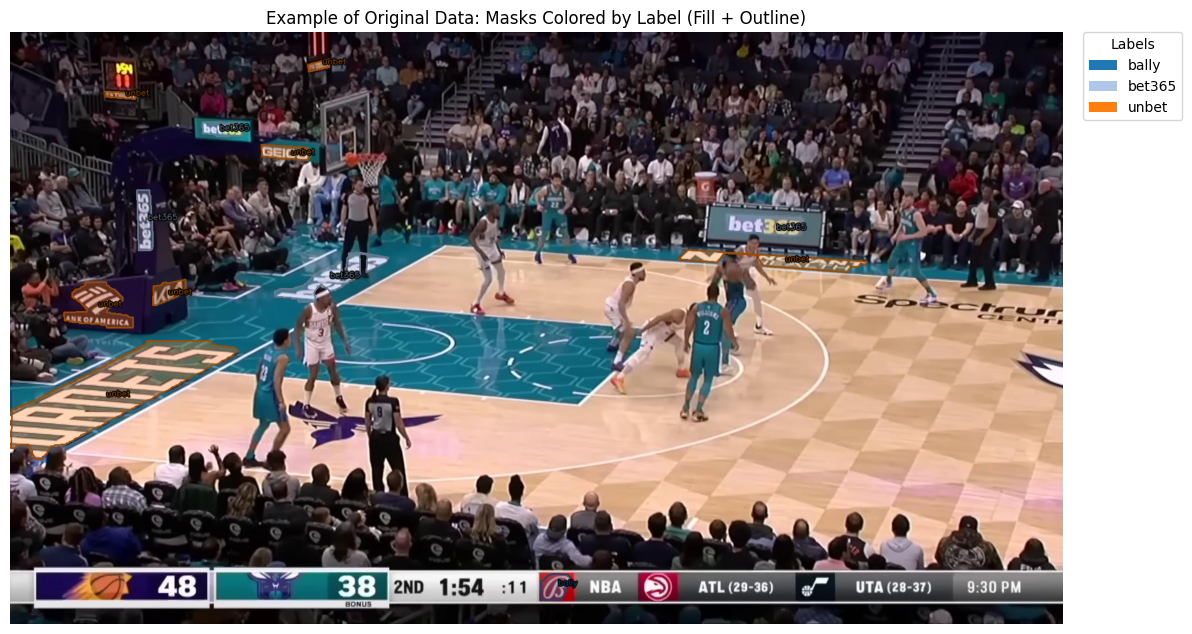

In [18]:
"""
Script: visualize_labelme_masks.py

Purpose:
    - Load a LabelMe JSON and its corresponding image.
    - Color each polygon mask by label (distinct color per label).
    - Draw darker outlines and (optional) label names at polygon centroids.
    - Show a legend mapping labels to colors.

Inputs:
    - image_path: Path to the image file.
    - json_path:  Path to the LabelMe JSON file describing shapes/polygons.

Outputs:
    - A matplotlib window displaying the blended masks and outlines.
    - (Optional) You can save the figure with plt.savefig("output.png", dpi=200, bbox_inches="tight").

Requirements:
    - Python 3.x
    - OpenCV (cv2), NumPy, Matplotlib
"""

# === PATHS ===
image_path = r"data_json\What_A_Move_1705_khaihoan2003_000693.jpg"
json_path  = r"data_json\What_A_Move_1705_khaihoan2003_000693.json"

# === LOAD IMAGE (RGB for consistent coloring) ===
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Cannot read image: {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === CREATE OVERLAY FOR FILLS (keeps original image intact) ===
overlay = image.copy()

# === LOAD LABELME JSON ===
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

shapes = data.get("shapes", [])
if not shapes:
    raise ValueError("No shapes found in JSON.")

# === BUILD A COLOR MAP: label -> RGB (using matplotlib's tab20) ===
unique_labels = sorted({s.get("label", "") for s in shapes if s.get("label")})
cmap = cm.get_cmap("tab20")  # 20 distinct colors
label2color = {}
for i, lb in enumerate(unique_labels):
    r, g, b, _ = cmap(i % 20)  # floats in [0, 1]
    label2color[lb] = (int(r * 255), int(g * 255), int(b * 255))  # convert to 0–255 RGB

def darker(rgb, factor=0.6):
    """Return a darker variant of an RGB color for crisp polygon outlines."""
    return tuple(max(0, int(c * factor)) for c in rgb)

# === DRAW FILLED POLYGONS ON THE OVERLAY ===
for shape in shapes:
    label  = shape.get("label", "")
    points = np.array(shape.get("points", []), dtype=np.int32)

    # Skip invalid/non-polygon shapes
    if points.ndim != 2 or points.shape[0] < 3:
        continue

    fill_color = label2color.get(label, (255, 0, 0))  # fallback to red if label missing
    cv2.fillPoly(overlay, [points], color=fill_color)

# === BLEND OVERLAY WITH THE ORIGINAL IMAGE ===
alpha = 0.3  # transparency of fills (0: transparent, 1: opaque)
blended = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

# === DRAW OUTLINES AND OPTIONAL LABEL TEXT ON TOP (sharp, non-blended) ===
for shape in shapes:
    label  = shape.get("label", "")
    points = np.array(shape.get("points", []), dtype=np.int32)

    if points.ndim != 2 or points.shape[0] < 3:
        continue

    # Outline color: a darker version of the fill color
    edge_color = darker(label2color.get(label, (255, 0, 0)), 0.6)
    cv2.polylines(blended, [points], isClosed=True, color=edge_color, thickness=2)

    # Optional: place label text near the polygon centroid (with black outline for readability)
    cx, cy = np.mean(points, axis=0).astype(int)
    cv2.putText(blended, label, (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(blended, label, (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, edge_color, 1, cv2.LINE_AA)

# === BUILD LEGEND (label-color mapping) ===
legend_handles = [
    Patch(facecolor=np.array(label2color[l]) / 255.0, edgecolor='none', label=l)
    for l in unique_labels
]

# === DISPLAY ===
plt.figure(figsize=(12, 12))
plt.imshow(blended)
plt.axis('off')
plt.title("Example of Original Data: Masks Colored by Label (Fill + Outline)")
if legend_handles:
    plt.legend(handles=legend_handles, title="Labels",
               bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()


Here is an example of how we label our data. In which:
- Regular advertising logos will have the label name "unbet".
- Betting advertising logos will have the label name of the bookmaker itself.

The logos can be seen in the following locations:
- Around the outside of the playing field.
- On advertising screens.
- On the 2 basketball hoops.

## 4. Train–Validation Split Statistics.

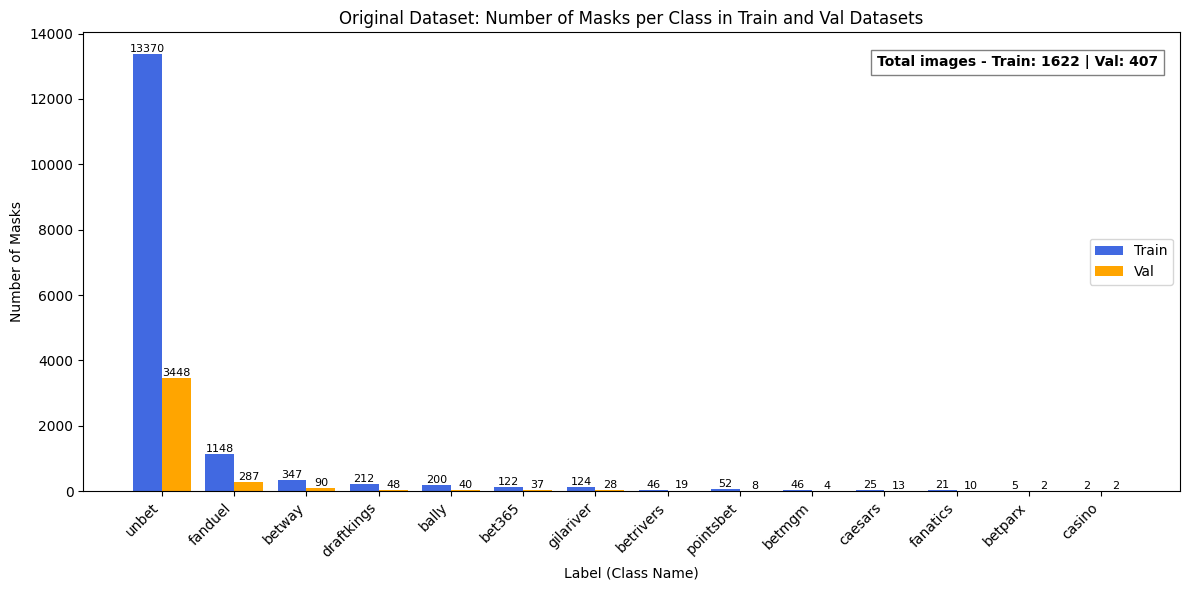

In [22]:
"""
Script: train_val_label_distribution.py

Purpose:
    - Count annotation labels in the Train and Validation splits from LabelMe JSON files.
    - Compare per-class mask counts between Train and Val.
    - Plot a grouped bar chart (Train vs. Val) with counts annotated on each bar.
    - Display total image counts for Train and Val in the chart.

Inputs:
    - train_folder_path: Path to the Train split JSON directory.
    - val_folder_path:   Path to the Validation (Val) split JSON directory.

Outputs:
    - A matplotlib bar chart window.
    - (Optional) Save the figure with:
        plt.savefig("train_val_label_distribution.png", dpi=200, bbox_inches="tight")

Requirements:
    - Python 3.x
    - matplotlib
"""

# === CONFIGURATION ===
train_folder_path = r"data_split_json/train"
val_folder_path   = r"data_split_json/val"


def count_labels_in_folder(folder_path: str) -> tuple[Counter, int]:
    """
    Count label occurrences (masks) and the number of images that contain at least one label
    within a given folder of LabelMe JSON files.

    Logic:
        - Iterate over all *.json files in the folder (non-recursive).
        - For each JSON, count occurrences of each "label" under "shapes".
        - Increment image_count if the JSON has at least one labeled shape.

    Args:
        folder_path (str): Directory containing LabelMe JSON files.

    Returns:
        tuple[Counter, int]:
            - Counter: label -> total mask count in this folder
            - int:     number of images (JSONs) that contain >= 1 labeled shape
    """
    label_counter = Counter()
    image_count = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            json_path = os.path.join(folder_path, filename)
            try:
                with open(json_path, "r", encoding="utf-8") as f:
                    data = json.load(f)

                has_label = False
                for shape in data.get("shapes", []):
                    label = shape.get("label")
                    if label:
                        label_counter[label] += 1
                        has_label = True

                if has_label:
                    image_count += 1

            except Exception as e:
                print(f"Error reading {filename}: {e}")

    return label_counter, image_count


# === COUNT LABELS FOR TRAIN & VAL ===
train_labels, train_images = count_labels_in_folder(train_folder_path)
val_labels,   val_images   = count_labels_in_folder(val_folder_path)

# === UNION OF ALL LABELS (FOR CONSISTENT AXIS ORDER) ===
all_labels = sorted(set(train_labels.keys()) | set(val_labels.keys()))

# Sort labels by total masks (train + val) in descending order for readability
sorted_labels = sorted(
    all_labels,
    key=lambda lbl: train_labels.get(lbl, 0) + val_labels.get(lbl, 0),
    reverse=True
)

train_counts = [train_labels.get(label, 0) for label in sorted_labels]
val_counts   = [val_labels.get(label, 0)   for label in sorted_labels]

# === PLOT: GROUPED BAR CHART (TRAIN VS. VAL) ===
x = range(len(sorted_labels))
bar_width = 0.4

plt.figure(figsize=(12, 6))
bars_train = plt.bar([i - bar_width / 2 for i in x], train_counts,
                     width=bar_width, label="Train", color="royalblue")
bars_val   = plt.bar([i + bar_width / 2 for i in x], val_counts,
                     width=bar_width, label="Val", color="orange")

# Annotate each bar with its numeric value
for bar in list(bars_train) + list(bars_val):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        str(height),
        ha="center",
        va="bottom",
        fontsize=8
    )

# Show total images for Train and Val in the top-right corner (axes coords)
plt.text(
    0.98, 0.95,
    f"Total images - Train: {train_images} | Val: {val_images}",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    fontsize=10,
    fontweight="bold",
    bbox=dict(facecolor="white", edgecolor="gray")
)

# Axis labels and title
plt.ylabel("Number of Masks")
plt.xlabel("Label (Class Name)")
plt.title("Original Dataset: Number of Masks per Class in Train and Val Datasets")

# X tick labels (rotated for readability)
plt.xticks(x, sorted_labels, rotation=45, ha="right")

plt.legend()
plt.tight_layout()
# Optional:
# plt.savefig("train_val_label_distribution.png", dpi=200, bbox_inches="tight")
plt.show()


We split the original data into two sets, train and val, and keep the ratio of classes in both sets. The purpose of training with this imbalanced data is because we want to compare it with the augmented data.